In [1]:
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import openai
from openai.embeddings_utils import get_embedding
import tiktoken

### 1.OpenAI Embeddings

In [6]:
openai.api_key = ""

# embedding_model = "text-embedding-ada-002"
# embedding_model = "text-similarity-davinci-001"
embedding_model = "text-similarity-ada-001"
embedding_encoding = "cl100k_base"  # This the encoding for text-embedding-ada-002
max_tokens = 8000  # The maximum for text-embedding-ada-002 is 8191

def compute_embeddings(df, asr_column_name: str) :
    # Omit trainings that are too long to embed
    encoding = tiktoken.get_encoding(embedding_encoding)
    df["n_tokens"] = df[asr_column_name].apply(lambda x: len(encoding.encode(x)))
    df = df[df.n_tokens <= max_tokens]
    # Compute embeddings
    df[f"embedding_{asr_column_name}"] = df[asr_column_name].apply(lambda x: get_embedding(x, engine=embedding_model))
    return df

In [3]:
df = pd.read_csv("../1.Database/dataset_out_of_place_open_responses.csv")

##### 1.1 Preprocess text

In [9]:
from clean_asr_service import CleanASRService

cleanASRservice = CleanASRService()

# Normalize text, delete duplicates etc
df["cleaned_asr"] = df.asr.apply(lambda x: cleanASRservice.execute(x, delete_stopwords=False))

# Normalize text, delete duplicates etc + delete stopwords
# Not use "no" and "sí" as stopwords
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword_es.remove("sí")
stopword_es.remove("no")
df["cleaned_asr_without_stopw"] = df.asr.apply(lambda x: cleanASRservice.execute(x, stopwords_list=stopword_es,delete_stopwords=True))

#### 1.2 Compute OpenAI Embeddings

In [10]:
df = compute_embeddings(df,"asr")
df = compute_embeddings(df,"cleaned_asr")
df = compute_embeddings(df,"cleaned_asr_without_stopw")
# Save encoding database
df.to_csv(f"OpenAI_{embedding_model}_embeddings.csv")

### 2. Visualize real labels in embeddings using t-SNE

In [ ]:
from sklearn.preprocessing import LabelEncoder

Text(0.5, 1.0, 'embeddings + t-SNE by label')

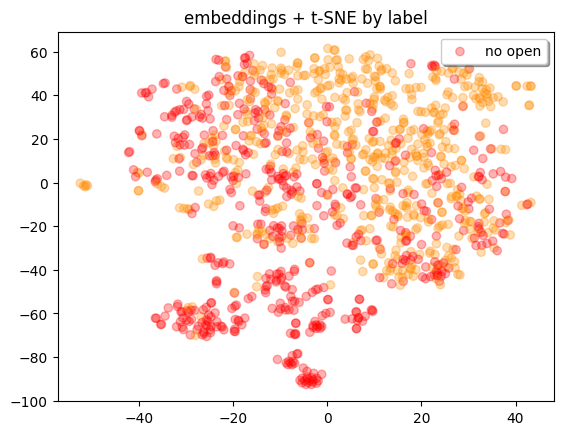

In [13]:
# Convert to a list of lists of floats
matrix = np.array(df.embedding_asr.apply(eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

# Encode targets
le = LabelEncoder()
encoded_label = le.fit_transform(df2.label)
df["encoded_label"] = encoded_label

# 2 targets: Out-of-place open responses vs No open
colors = ["red", "darkorange"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.encoded_label
label_classes = list(set(df.encoded_label))

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.legend(labels=le.classes_,fancybox=True, shadow=True,loc='upper right')
plt.title("embeddings + t-SNE by label")

### 3. KMeans in embeddings and visualize clusters using t-SNE

Number of clusters: 2


/home/andrea/Desktop/detect_open_responses/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'KMeans + t-SNE')

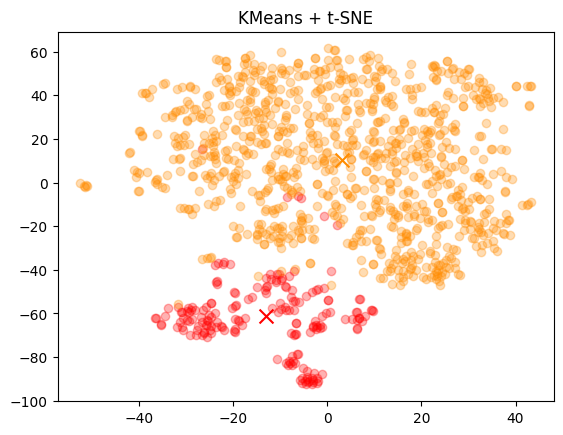

In [14]:
matrix = np.vstack((df.embedding_asr.apply(eval).apply(np.array)).values)
matrix.shape

# K-means
n_clusters = len(list(set(df.label)))
print(f"Number of clusters: {n_clusters}")
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["cluster"] = labels

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["red", "darkorange"]):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("KMeans + t-SNE")